# BOSS

### Imports

In [1]:
# some_file.py
import sys
import yaml
# insert at 1, 0 is the script path (or '' in REPL)

sys.path.insert(1, '/home/jaimerz/PhD/xCell')

from xcell.mappers import MapperBOSS
from xcell.mappers import utils
from xcell.cls.data import Data
from xcell.cls.cl import Cl
from xcell.cls.cov import Cov
from astropy.io import fits
from astropy.table import Table
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import numpy as np

### Configurations

In [2]:
data = Data(data_path="../config_files/master.yml")

/home/jaimerz/PhD/xCell/xcell/cls/data.py:416: UserWarning: A YML file was found in outdir: ../reruns/. Using it                  instead of input config.
  warn(f'A YML file was found in outdir: {outdir}. Using it \


### Mappers

In [3]:
CMASS = data.get_mapper("SDSS__CMASS")
LOWZ = data.get_mapper("SDSS__LOWZ")


In [4]:
CMASS_map = CMASS.get_signal_map()
LOWZ_map = LOWZ.get_signal_map()

Reading ../reruns/SDSS_CMASS_signal_map_coordC_ns512.fits.gz
Reading ../reruns/SDSS_LOWZ_signal_map_coordC_ns512.fits.gz


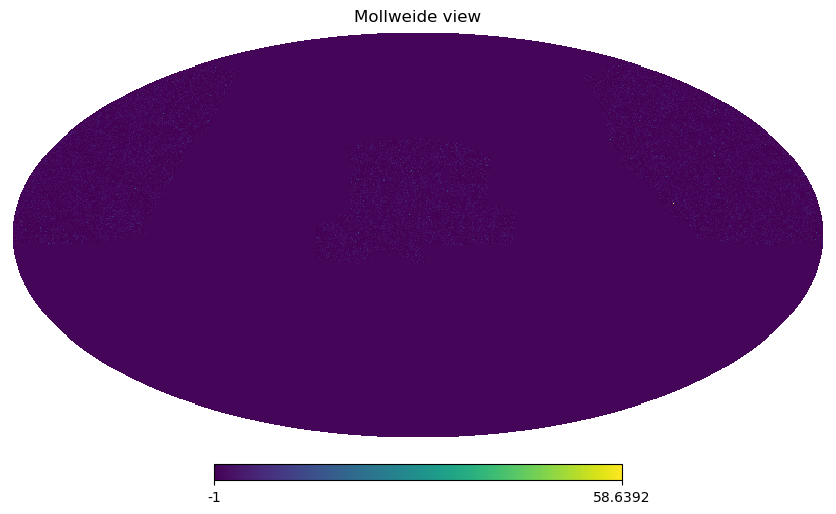

In [5]:
hp.visufunc.mollview(map=np.array(CMASS_map)[0])

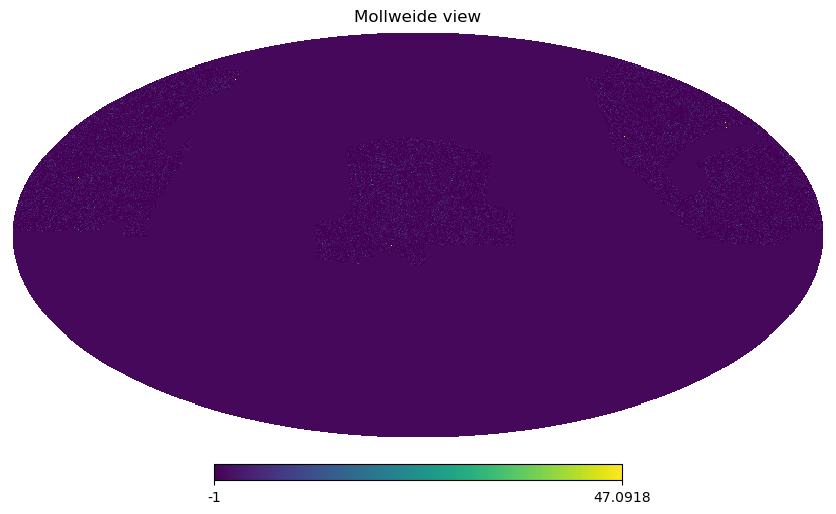

In [6]:
hp.visufunc.mollview(map=np.array(LOWZ_map)[0])

### Cl's

In [7]:
cl_CMASS_CMASS = Cl(data.data, "SDSS__CMASS", "SDSS__CMASS")
cl_LOWZ_LOWZ = Cl(data.data, "SDSS__LOWZ", "SDSS__LOWZ")

cl_CMASS_CMASS = cl_CMASS_CMASS.get_ell_cl()
cl_LOWZ_LOWZ = cl_LOWZ_LOWZ.get_ell_cl()

Computing Cell for SDSS__CMASS SDSS__CMASS
Reading ../reruns/SDSS_CMASS_signal_map_coordC_ns512.fits.gz
Reading ../reruns/mask_mask_CMASS_coordC_ns512.fits.gz
Reading ../reruns/SDSS_SDSS/w__mask_CMASS__mask_CMASS.fits
calculing nl from weights
Saving ../reruns/SDSS_CMASS_Nell_coordC_ns512.npz
Saving ../reruns/SDSS_SDSS/cl_SDSS__CMASS_SDSS__CMASS.npz
Computing Cell for SDSS__LOWZ SDSS__LOWZ
Reading ../reruns/SDSS_LOWZ_signal_map_coordC_ns512.fits.gz
Reading ../reruns/mask_mask_LOWZ_coordC_ns512.fits.gz
Saving ../reruns/SDSS_SDSS/w__mask_LOWZ__mask_LOWZ.fits
calculing nl from weights
Saving ../reruns/SDSS_LOWZ_Nell_coordC_ns512.npz
Saving ../reruns/SDSS_SDSS/cl_SDSS__LOWZ_SDSS__LOWZ.npz


### Covariance Matrix

In [9]:
cov_CMASS_CMASS_CMASS_CMASS = Cov(data.data, "SDSS__CMASS", "SDSS__CMASS", "SDSS__CMASS", "SDSS__CMASS")
cov_LOWZ_LOWZ_LOWZ_LOWZ = Cov(data.data, "SDSS__LOWZ", "SDSS__LOWZ", "SDSS__LOWZ", "SDSS__LOWZ")

cov_CMASS_CMASS_CMASS_CMASS = cov_CMASS_CMASS_CMASS_CMASS.get_covariance()
cov_LOWZ_LOWZ_LOWZ_LOWZ = cov_LOWZ_LOWZ_LOWZ_LOWZ.get_covariance()

Get C_ells. It took 6.037155787150065e-05 min


Reading ../reruns/SDSS_SDSS/w__mask_CMASS__mask_CMASS.fits
Get workspaces. It took 3.4308433532714845e-05 min
Reading ../reruns/SDSS_CMASS_signal_map_coordC_ns512.fits.gz
Reading ../reruns/mask_mask_CMASS_coordC_ns512.fits.gz
Saving ../reruns/cov/cw__mask_CMASS__mask_CMASS__mask_CMASS__mask_CMASS.fits
Get covariance workspace. It took 0.06653226613998413 min
Computed Gaussian covariance. It took 0.00022290945053100587 min
Added all covariances terms. It took 4.0928522745768227e-07 min
Saving ../reruns/cov/cov_SDSS__CMASS_SDSS__CMASS_SDSS__CMASS_SDSS__CMASS.npz
Saved cov npz file. It took 5.2364667256673175e-05 min
Get C_ells. It took 7.701317469278971e-05 min
Reading ../reruns/SDSS_SDSS/w__mask_LOWZ__mask_LOWZ.fits
Get workspaces. It took 4.7763188680013025e-06 min
Reading ../reruns/SDSS_LOWZ_signal_map_coordC_ns512.fits.gz
Reading ../reruns/mask_mask_LOWZ_coordC_ns512.fits.gz
Saving ../reruns/cov/cw__mask_LOWZ__mask_LOWZ__mask_LOWZ__mask_LOWZ.fits
Get covariance workspace. It took 0.0

In [10]:
err_CMASS_CMASS = np.sqrt(np.diag(cov_CMASS_CMASS_CMASS_CMASS))
err_LOWZ_LOWZ = np.sqrt(np.diag(cov_LOWZ_LOWZ_LOWZ_LOWZ))

### Theory Cl's

In [11]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)

CMASS_nz = CMASS.get_nz()
LOWZ_nz = LOWZ.get_nz()

CMASS_z = CMASS_nz[0]
CMASS_dNdz = CMASS_nz[1]
LOWZ_z = LOWZ_nz[0]
LOWZ_dNdz = LOWZ_nz[1]

b_CMASS = data.data["tracers"]["SDSS__CMASS"]["bias"]*np.ones(len(CMASS_z))
b_LOWZ = data.data["tracers"]["SDSS__LOWZ"]["bias"]*np.ones(len(LOWZ_z))

tracer_CMASS = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(CMASS_z, CMASS_dNdz), bias=(CMASS_z, b_CMASS))
tracer_LOWZ = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(LOWZ_z, LOWZ_dNdz), bias=(LOWZ_z, b_LOWZ))

clt_CMASS_CMASS = ccl.angular_cl(cosmo, tracer_CMASS, tracer_CMASS, cl_CMASS_CMASS[0]) 
clt_LOWZ_LOWZ = ccl.angular_cl(cosmo, tracer_LOWZ, tracer_LOWZ, cl_LOWZ_LOWZ[0]) 

Reading ../reruns/SDSS_CMASS_dndz.npz
Reading ../reruns/SDSS_LOWZ_dndz.npz


### Comparison

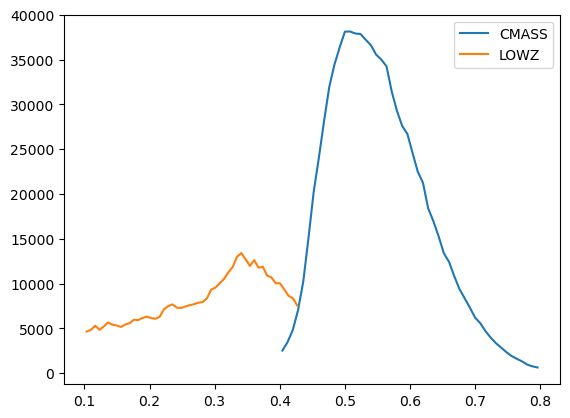

In [12]:
plt.plot(CMASS_z, CMASS_dNdz, label='CMASS')
plt.plot(LOWZ_z, LOWZ_dNdz, label='LOWZ')
plt.legend()
plt.show()

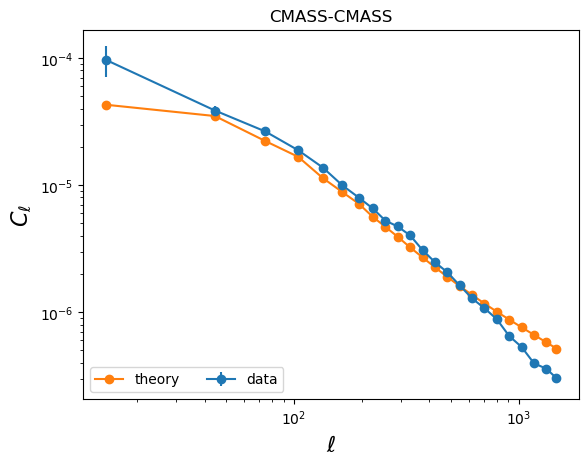

In [13]:
plt.errorbar(cl_CMASS_CMASS[0], cl_CMASS_CMASS[1][0], yerr=err_CMASS_CMASS, fmt='o-', label='data')
plt.plot(cl_CMASS_CMASS[0], clt_CMASS_CMASS, 'o-', label='theory')
plt.title('CMASS-CMASS')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale("log")
plt.yscale("log")
plt.show()

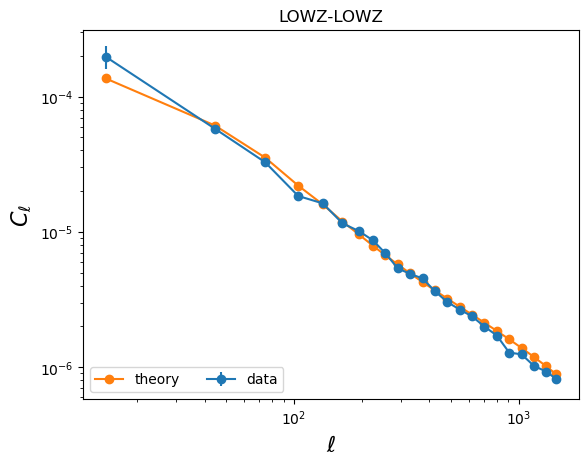

In [14]:
plt.errorbar(cl_LOWZ_LOWZ[0], cl_LOWZ_LOWZ[1][0], yerr=err_LOWZ_LOWZ, fmt='o-', label='data')
plt.plot(cl_LOWZ_LOWZ[0], clt_LOWZ_LOWZ, 'o-', label='theory')
plt.title('LOWZ-LOWZ')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.xscale("log")
plt.yscale("log")
plt.show()